# First Place - Single Model - CV 1.016 LB 1.016 - Wow!
I'm excited to share this notebook which achieves `Gold Medal Single Model` in Kaggle's December 2024 Insurance playground competition! Often in Kaggle competitons, it requires an ensemble of many models to achieve gold medal. Therefore it is an exciting accomplishment to build a single model which achieves gold medal!

The secret to this model's success is using [RAPIDS cuDF-Pandas][2] to engineer features. Using a for-loop, we searched thousands of combinations of original columns to find combinations that when combined with Target Encoding and Count Encoding improved CV and LB score. I shared the concept of combining columns with Target Encoding in September's competition [here][1]. (In that competition, we used all combinations of 2 and 3 because there were only 286 total).

In this competition, there were 145k combinations (of 2,3,4,5,6), so we can't use them all. We must search for the best ones. Searching was done using [RAPIDS cuDF-Pandas][2] and GPU. In total there are 145,000 combinations of 2,3,4,5,6 columns that can be extracted from the original 23 columns. For each of these 145k combinations, we must combine the dataframe columns and compute groupby aggregate target encoding and count encoding. Then we have to a train a model with the new features added. This requires lots of time and was made possible by using the blazing speed of GPU! We found 170 powerful combos and share the top 20 in this notebook.

# How To Improve
This notebook takes under 2 hours to run on Kaggle's T4 GPU 16GB and achieves `CV = 1.019` and `LB = 1.019`. We can improve this model by adding more features. My final submission for December's 2024 playground competition adds 400 more engineered features. We can also improve CV and LB by decreasing learning rate by a factor of 10x and increasing number of iterations by a factor of 10x. And when performing TE, we can use 10 inner nested folds instead of 5. With these changes, my final submission achieves `CV = 1.016` and `LB = 1.016`, WOW!

[1]: https://www.kaggle.com/code/cdeotte/rapids-cuml-lasso-lb-0-72500-cv-0-72800
[2]: https://rapids.ai/cudf-pandas/

# Zero Code Change GPU Acceleration!
The following single magic command converts all subsequent CPU Pandas calls to GPU RAPIDS cuDF calls! This gives us a huge speedup! Woohoo! (Note in order to import RAPIDS cuDF 24.12, we attach `Utility Script` [here][1] to our notebook)

[1]: https://www.kaggle.com/code/cdeotte/rapids-cudf-24-12-cuml-24-12

In [1]:
%load_ext cudf.pandas

# Load Train and Test
We load train and test data. And we convert datatime column into year, month, day, day of week, and elapsed seconds since 1970.

In [2]:
import numpy as np, pandas as pd
pd.set_option('display.max_columns', 500)

train = pd.read_csv("/kaggle/input/playground-series-s4e12/train.csv")
train["Policy Start Date"] = pd.to_datetime( train["Policy Start Date"] )
train["year"] = train["Policy Start Date"].dt.year.astype("float32")
train["month"] = train["Policy Start Date"].dt.month.astype("float32")
train["day"] = train["Policy Start Date"].dt.day.astype("float32")
train["dow"] = train["Policy Start Date"].dt.dayofweek.astype("float32")
train["seconds"] = (train["Policy Start Date"].astype("int64") // 10**9).astype("float32")
train["y"] = np.log1p( train["Premium Amount"] )
print( train.shape )
train.head()

(1200000, 27)


,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,year,month,day,dow,seconds,y
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0,2023.0,12.0,23.0,5.0,1.703345e+09,7.962067
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,<NA>,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0,2023.0,6.0,12.0,0.0,1.686583e+09,7.302496
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,<NA>,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0,2023.0,9.0,30.0,5.0,1.696087e+09,6.342121
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,<NA>,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0,2024.0,6.0,12.0,2.0,1.718206e+09,6.641182
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0,2021.0,12.0,1.0,2.0,1.638372e+09,7.612337


In [3]:
test = pd.read_csv("/kaggle/input/playground-series-s4e12/test.csv")
test["Policy Start Date"] = pd.to_datetime( test["Policy Start Date"] )
test["year"] = test["Policy Start Date"].dt.year.astype("float32")
test["month"] = test["Policy Start Date"].dt.month.astype("float32")
test["day"] = test["Policy Start Date"].dt.day.astype("float32")
test["dow"] = test["Policy Start Date"].dt.dayofweek.astype("float32")
test["seconds"] = (test["Policy Start Date"].astype("int64") // 10**9).astype("float32")
print( test.shape )
test.head()

(800000, 25)


,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,year,month,day,dow,seconds
0,1200000,28.0,Female,2310.0,<NA>,4.0,Bachelor's,Self-Employed,7.657981,Rural,Basic,<NA>,19.0,<NA>,1.0,2023-06-04 15:21:39.245086,Poor,Yes,Weekly,House,2023.0,6.0,4.0,6.0,1.685892e+09
1,1200001,31.0,Female,126031.0,Married,2.0,Master's,Self-Employed,13.381379,Suburban,Premium,<NA>,14.0,372.0,8.0,2024-04-22 15:21:39.224915,Good,Yes,Rarely,Apartment,2024.0,4.0,22.0,0.0,1.713799e+09
2,1200002,47.0,Female,17092.0,Divorced,0.0,PhD,Unemployed,24.354527,Urban,Comprehensive,<NA>,16.0,819.0,9.0,2023-04-05 15:21:39.134960,Average,Yes,Monthly,Condo,2023.0,4.0,5.0,2.0,1.680708e+09
3,1200003,28.0,Female,30424.0,Divorced,3.0,PhD,Self-Employed,5.136225,Suburban,Comprehensive,1.0,3.0,770.0,5.0,2023-10-25 15:21:39.134960,Poor,Yes,Daily,House,2023.0,10.0,25.0,2.0,1.698247e+09
4,1200004,24.0,Male,10863.0,Divorced,2.0,High School,Unemployed,11.844155,Suburban,Premium,<NA>,14.0,755.0,7.0,2021-11-26 15:21:39.259788,Average,No,Weekly,House,2021.0,11.0,26.0,4.0,1.637940e+09


# Label Encode Categorical Features
We identify and label encode all categorical features. We convert all data to either `int32` or `float32` for reduced memory utilization. We identify which numerical or categorical features have cardinality greater than 8 for special attention later.

In [4]:
RMV = ["id","Policy Start Date","Premium Amount","y"]
FEATURES = [c for c in train.columns if not c in RMV]
combined = pd.concat([train,test],axis=0,ignore_index=True)

CATS = []
HIGH_CARDINALITY = []
print(f"THE {len(FEATURES)} BASIC FEATURES ARE:")

for c in FEATURES:
    ftype = "numerical"
    if combined[c].dtype=="object":
        CATS.append(c)
        combined[c] = combined[c].fillna("NAN")
        combined[c],_ = combined[c].factorize()
        combined[c] -= combined[c].min()
        ftype = "categorical"
    if combined[c].dtype=="int64":
        combined[c] = combined[c].astype("int32")
    elif combined[c].dtype=="float64":
        combined[c] = combined[c].astype("float32")
        
    n = combined[c].nunique()
    print(f"{c} ({ftype}) with {n} unique values")
    if n>=9: HIGH_CARDINALITY.append(c)
    
train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):].reset_index(drop=True).copy()

print("\nTHE FOLLOWING HAVE 9 OR MORE UNIQUE VALUES:", HIGH_CARDINALITY )

THE 23 BASIC FEATURES ARE:
Age (numerical) with 47 unique values
Gender (categorical) with 2 unique values
Annual Income (numerical) with 97540 unique values
Marital Status (categorical) with 4 unique values
Number of Dependents (numerical) with 5 unique values
Education Level (categorical) with 4 unique values
Occupation (categorical) with 4 unique values
Health Score (numerical) with 640260 unique values
Location (categorical) with 3 unique values
Policy Type (categorical) with 3 unique values
Previous Claims (numerical) with 10 unique values
Vehicle Age (numerical) with 20 unique values
Credit Score (numerical) with 550 unique values
Insurance Duration (numerical) with 9 unique values
Customer Feedback (categorical) with 4 unique values
Smoking Status (categorical) with 2 unique values
Exercise Frequency (categorical) with 4 unique values
Property Type (categorical) with 3 unique values
year (numerical) with 6 unique values
month (numerical) with 12 unique values
day (numerical) wit

# Feature Engineering 120 Features!
In another notebook, we ran a `for-loop` to try different combinations of (2,3,4,5,or 6) columns. Each iteration,we added a random new combination of columns and evaluated whether it improved CV score or not. If it improved CV score we saved it to a list. This is called `forward feature selection`. By using GPU (RAPIDS cuDF-Pandas), we were able to try thousands of combinations quickly! We found 20 powerful column combinations defined below!

For each of these column combinations, we will create 6 features, namely TE (target encode) mean, TE median, TE min, TE max, TE nunique, and CE (count encode). This generates 120 features!

In [5]:
lists2 = [['Annual Income', 'Health Score'], ['Credit Score', 'Health Score'], ['Customer Feedback', 'Gender', 'Marital Status', 'Occupation', 'Smoking Status', 'year'], ['Exercise Frequency', 'Health Score'], ['Health Score', 'Marital Status'], ['Education Level', 'Gender', 'Health Score'], ['Health Score', 'Occupation'], ['Age', 'Health Score'], ['Health Score', 'dow'], ['Age', 'Exercise Frequency', 'Location'], ['Health Score', 'Smoking Status', 'month'], ['Health Score', 'Location', 'Policy Type'], ['Health Score', 'Insurance Duration'], ['Health Score', 'Number of Dependents'], ['Customer Feedback', 'Exercise Frequency', 'Previous Claims', 'Property Type', 'dow'], ['Customer Feedback', 'Health Score'], ['Health Score', 'Property Type'], ['Health Score', 'day', 'seconds'], ['Health Score', 'year'], ['Age', 'Gender', 'Insurance Duration', 'year']]
print(f"We have {len(lists2)} powerful combination of columns!")

We have 20 powerful combination of columns!


# Target Encoding Function
This function is written using CPU Pandas (based on code [here][2]). However when we add `%load_ext cudf.pandas` magic at the start of our notebook, this notebook will be executed using GPU [RAPIDS cuDF][7] and made faster! Based on the number of rows of train data we are transforming, we can witness speed ups varying from 10x to 100x! (See notebook [here][1] to see how much speed up we can expect using GPU vs CPU for various dataframe sizes when executing various dataframe operations).

For more information about Target Encoding, see blog [here][2] and tutorial [here][3]. [KGMON][6] Theo published a notebook [here][4] and [KGMON][6] will present a live workshop at NVIDIA GTC in March 2025 [here][5]. We hope to see you there!

[1]: https://www.kaggle.com/code/cdeotte/compare-cpu-dataframes-to-gpu-dataframes
[2]: https://medium.com/rapids-ai/target-encoding-with-rapids-cuml-do-more-with-your-categorical-data-8c762c79e784
[3]: https://github.com/rapidsai/deeplearning/blob/main/RecSys2020Tutorial/03_3_TargetEncoding.ipynb
[4]: https://www.kaggle.com/code/theoviel/explaining-and-accelerating-target-encoding
[5]: https://www.nvidia.com/gtc/sessions/gtc-data-science/
[6]: https://www.nvidia.com/en-us/ai-data-science/kaggle-grandmasters/
[7]: https://docs.rapids.ai/install/

In [6]:
def target_encode(train, valid, test, col, target="y", kfold=5, smooth=20, agg="mean"):

    train['kfold'] = ((train.index) % kfold)
    col_name = '_'.join(col)
    train[f'TE_{agg.upper()}_' + col_name] = 0.
    for i in range(kfold):
        
        df_tmp = train[train['kfold']!=i]
        if agg=="mean": mn = train[target].mean()
        elif agg=="median": mn = train[target].median()
        elif agg=="min": mn = train[target].min()
        elif agg=="max": mn = train[target].max()
        elif agg=="nunique": mn = 0
        df_tmp = df_tmp[col + [target]].groupby(col).agg([agg, 'count']).reset_index()
        df_tmp.columns = col + [agg, 'count']
        if agg=="nunique":
            df_tmp['TE_tmp'] = df_tmp[agg] / df_tmp['count']
        else:
            df_tmp['TE_tmp'] = ((df_tmp[agg]*df_tmp['count'])+(mn*smooth)) / (df_tmp['count']+smooth)
        df_tmp_m = train[col + ['kfold', f'TE_{agg.upper()}_' + col_name]].merge(df_tmp, how='left', left_on=col, right_on=col)
        df_tmp_m.loc[df_tmp_m['kfold']==i, f'TE_{agg.upper()}_' + col_name] = df_tmp_m.loc[df_tmp_m['kfold']==i, 'TE_tmp']
        train[f'TE_{agg.upper()}_' + col_name] = df_tmp_m[f'TE_{agg.upper()}_' + col_name].fillna(mn).values  
    
    df_tmp = train[col + [target]].groupby(col).agg([agg, 'count']).reset_index()
    if agg=="mean": mn = train[target].mean()
    elif agg=="median": mn = train[target].median()
    elif agg=="min": mn = train[target].min()
    elif agg=="max": mn = train[target].max()
    elif agg=="nunique": mn = 0
    df_tmp.columns = col + [agg, 'count']
    if agg=="nunique":
        df_tmp['TE_tmp'] = df_tmp[agg] / df_tmp['count']
    else:
        df_tmp['TE_tmp'] = ((df_tmp[agg]*df_tmp['count'])+(mn*smooth)) / (df_tmp['count']+smooth)
    df_tmp_m = valid[col].merge(df_tmp, how='left', left_on=col, right_on=col)
    valid[f'TE_{agg.upper()}_' + col_name] = df_tmp_m['TE_tmp'].fillna(mn).values
    valid[f'TE_{agg.upper()}_' + col_name] = valid[f'TE_{agg.upper()}_' + col_name].astype("float32")

    df_tmp_m = test[col].merge(df_tmp, how='left', left_on=col, right_on=col)
    test[f'TE_{agg.upper()}_' + col_name] = df_tmp_m['TE_tmp'].fillna(mn).values
    test[f'TE_{agg.upper()}_' + col_name] = test[f'TE_{agg.upper()}_' + col_name].astype("float32")

    train = train.drop('kfold', axis=1)
    train[f'TE_{agg.upper()}_' + col_name] = train[f'TE_{agg.upper()}_' + col_name].astype("float32")

    return(train, valid, test)

# Train XGBoost
We train a 20-fold XGBoost model using the 23 basic features and 120 feature engineered features. We will also encode the basic 23 features with some TE and CE. If you want to see the train and validation scores from the training process, click the "Show hidden output" at the end of the second code cell below.

In [7]:
from xgboost import XGBRegressor
import xgboost as xgb, time
print(f"Using XGBoost version",xgb.__version__)

Using XGBoost version 2.0.3


In [8]:
%%time

FOLDS = 20
from sklearn.model_selection import KFold
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof = np.zeros(len(train))
pred = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES+["y"] ].copy()
    y_train = train.loc[train_index,"y"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[FEATURES].copy()

    start = time.time()
    print(f"FEATURE ENGINEER {len(FEATURES)} COLUMNS and {len(lists2)} GROUPS: ",end="")
    for j,f in enumerate(FEATURES+lists2):

        if j<len(FEATURES): c = [f]
        else: c = f 
        print(f"({j+1}){c}",", ",end="")

        # LOW CARDINALITY FEATURES - TARGET ENCODE MEAN AND MEDIAN
        x_train, x_valid, x_test = target_encode(x_train, x_valid, x_test, c, smooth=20, agg="mean")
        x_train, x_valid, x_test = target_encode(x_train, x_valid, x_test, c, smooth=0, agg="median")

        # HIGH CARDINALITY FEATURES - TE MIN, MAX, NUNIQUE and CE
        if (j>=len(FEATURES)) | (c[0] in HIGH_CARDINALITY):
            x_train, x_valid, x_test = target_encode(x_train, x_valid, x_test, c, smooth=0, agg="min")
            x_train, x_valid, x_test = target_encode(x_train, x_valid, x_test, c, smooth=0, agg="max")
            x_train, x_valid, x_test = target_encode(x_train, x_valid, x_test, c, smooth=0, agg="nunique")
    
            # COUNT ENCODING (USING COMBINED TRAIN TEST)
            tmp = combined.groupby(c).y.count()
            nm = f"CE_{'_'.join(c)}"; tmp.name = nm
            x_train = x_train.merge(tmp, on=c, how="left")
            x_valid = x_valid.merge(tmp, on=c, how="left")
            x_test = x_test.merge(tmp, on=c, how="left")
            x_train[nm] = x_train[nm].astype("int32")
            x_valid[nm] = x_valid[nm].astype("int32")
            x_test[nm] = x_test[nm].astype("int32")
            
    end = time.time()
    elapsed = end-start
    print(f"Feature engineering took {elapsed:.1f} seconds")
    x_train = x_train.drop("y",axis=1)

    model = XGBRegressor(
        device="cuda",
        max_depth=8, 
        colsample_bytree=0.9, 
        subsample=0.9, 
        n_estimators=2_000, 
        learning_rate=0.01, 
        early_stopping_rounds=25,  
        eval_metric="rmse",
    )
    model.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],   
        verbose=100
    )

    # INFER OOF
    oof[test_index] = model.predict(x_valid)
    # INFER TEST
    pred += model.predict(x_test)

    m = np.sqrt(np.mean( (y_valid.to_numpy() - oof[test_index])**2.0 )) 
    print(f" => Fold {i+1} RMSLE = {m:.5f}")

# COMPUTE AVERAGE TEST PREDS
pred /= FOLDS

#########################
### Fold 1
#########################
FEATURE ENGINEER 23 COLUMNS and 20 GROUPS: (1)['Age'] , (2)['Gender'] , (3)['Annual Income'] , (4)['Marital Status'] , (5)['Number of Dependents'] , (6)['Education Level'] , (7)['Occupation'] , (8)['Health Score'] , (9)['Location'] , (10)['Policy Type'] , (11)['Previous Claims'] , (12)['Vehicle Age'] , (13)['Credit Score'] , (14)['Insurance Duration'] , (15)['Customer Feedback'] , (16)['Smoking Status'] , (17)['Exercise Frequency'] , (18)['Property Type'] , (19)['year'] , (20)['month'] , (21)['day'] , (22)['dow'] , (23)['seconds'] , (24)['Annual Income', 'Health Score'] , (25)['Credit Score', 'Health Score'] , (26)['Customer Feedback', 'Gender', 'Marital Status', 'Occupation', 'Smoking Status', 'year'] , (27)['Exercise Frequency', 'Health Score'] , (28)['Health Score', 'Marital Status'] , (29)['Education Level', 'Gender', 'Health Score'] , (30)['Health Score', 'Occupation'] , (31)['Age', 'Health Score'] , (32)['Health Score

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [13:20:36] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


 => Fold 1 RMSLE = 1.01907
#########################
### Fold 2
#########################
FEATURE ENGINEER 23 COLUMNS and 20 GROUPS: (1)['Age'] , (2)['Gender'] , (3)['Annual Income'] , (4)['Marital Status'] , (5)['Number of Dependents'] , (6)['Education Level'] , (7)['Occupation'] , (8)['Health Score'] , (9)['Location'] , (10)['Policy Type'] , (11)['Previous Claims'] , (12)['Vehicle Age'] , (13)['Credit Score'] , (14)['Insurance Duration'] , (15)['Customer Feedback'] , (16)['Smoking Status'] , (17)['Exercise Frequency'] , (18)['Property Type'] , (19)['year'] , (20)['month'] , (21)['day'] , (22)['dow'] , (23)['seconds'] , (24)['Annual Income', 'Health Score'] , (25)['Credit Score', 'Health Score'] , (26)['Customer Feedback', 'Gender', 'Marital Status', 'Occupation', 'Smoking Status', 'year'] , (27)['Exercise Frequency', 'Health Score'] , (28)['Health Score', 'Marital Status'] , (29)['Education Level', 'Gender', 'Health Score'] , (30)['Health Score', 'Occupation'] , (31)['Age', 'Health S

# Compute CV Score
Our model has a local CV score of 1.019, wow!

In [9]:
m = np.sqrt(np.mean( (train.y.values - oof)**2.0 )) 
print(f"Overall CV RMSLE = {m:.5f}")

Overall CV RMSLE = 1.01931


# XGB Top 25 Feature Importance
Here are the top 25 features of our XGBoost model based on "weight". (Alternatively, we can display top 25 by "gain" or "cover").

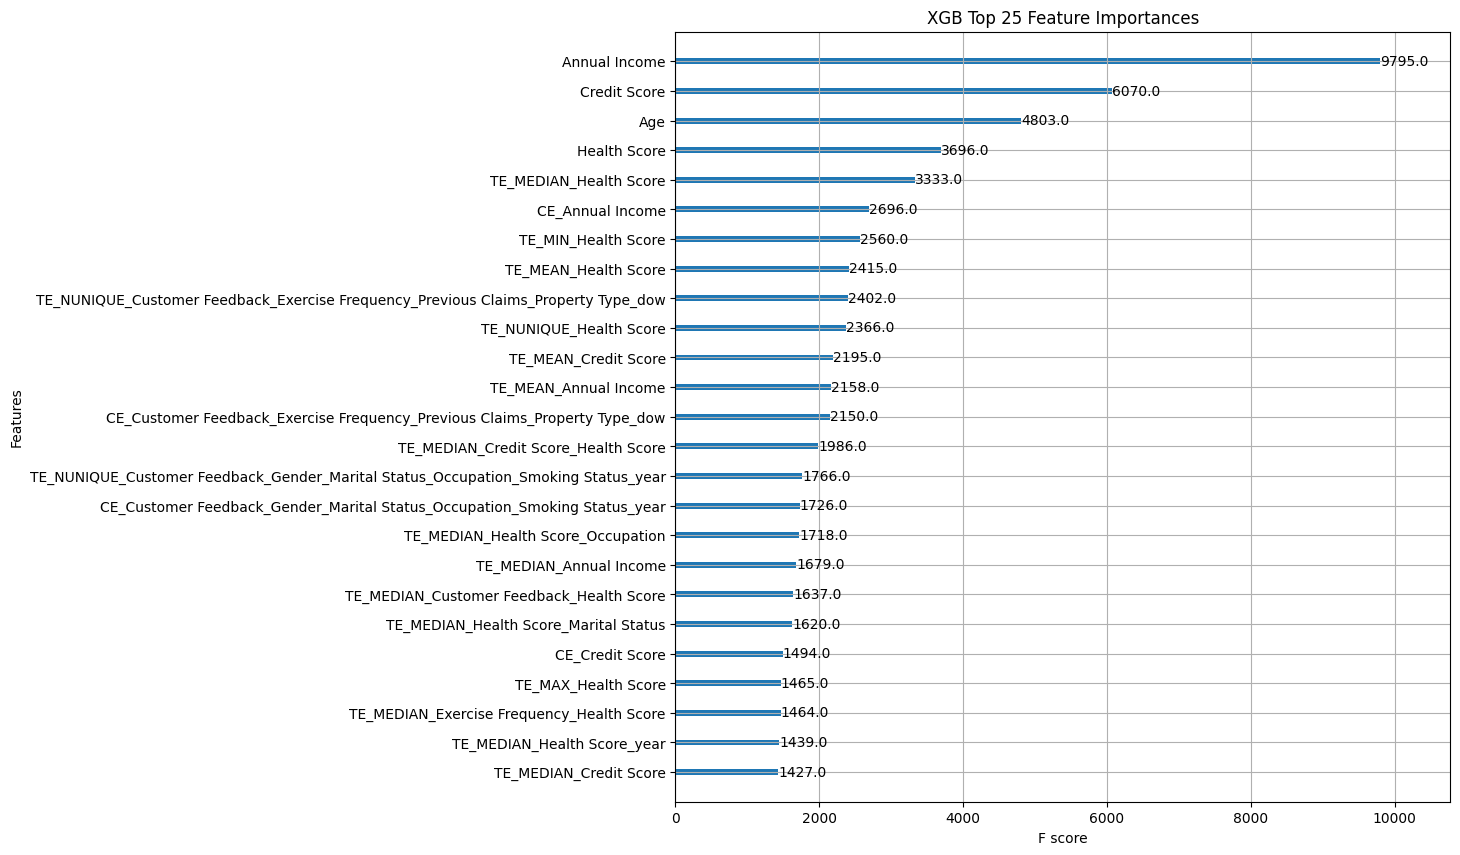

In [10]:
# Plot top 25 features by importance
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size if needed
xgb.plot_importance(
    model,
    ax=ax,
    max_num_features=25,  # Display only the top 25 features
    importance_type="weight",  # Options: 'weight', 'gain', 'cover', 'total_gain', 'total_cover'
)
plt.title("XGB Top 25 Feature Importances")
plt.show()

# Create Submission CSV
We write our submission CSV file to disk and submit to competition.

In [11]:
sub = pd.read_csv("/kaggle/input/playground-series-s4e12/sample_submission.csv")
sub["Premium Amount"] = np.exp( pred )-1
sub.to_csv("submission.csv",index=False)
print( sub.shape )
sub.head()

(800000, 2)


,id,Premium Amount
0,1200000,868.050982
1,1200001,928.541632
2,1200002,830.871212
3,1200003,782.367808
4,1200004,807.696679
